In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('/content/synthetic_delivery_data.csv')

# Preview
df.head()


,pickup_location,dropoff_location,order_time,dispatch_time,estimated_delivery_time,actual_delivery_time,delivery_distance_km,num_items,traffic_level,vehicle_type
0,Dublin 2,Dublin 1,26-01-2024 08:48,26-01-2024 08:52,26-01-2024 08:55,26-01-2024 08:55,1.66,3,Low,Car
1,Dublin 14,Dublin 2,24-02-2024 01:57,24-02-2024 02:04,24-02-2024 02:18,24-02-2024 02:19,5.08,0,Low,Bike
2,Dublin 15,Dublin 1,21-02-2024 10:03,21-02-2024 10:07,21-02-2024 10:30,21-02-2024 10:28,9.87,2,Medium,Car
3,Dublin 12,Dublin 15,26-01-2024 15:43,26-01-2024 15:56,26-01-2024 16:21,26-01-2024 16:19,8.55,2,High,Bike
4,Dublin 11,Dublin 9,26-01-2024 15:01,26-01-2024 15:04,26-01-2024 15:10,26-01-2024 15:08,3.28,3,Low,Bike


In [ ]:
df['order_time'] = pd.to_datetime(df['order_time'])
df['dispatch_time'] = pd.to_datetime(df['dispatch_time'])
df['estimated_delivery_time'] = pd.to_datetime(df['estimated_delivery_time'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Feature Engineering: calculate time deltas
df['dispatch_delay_minutes'] = (df['dispatch_time'] - df['order_time']).dt.total_seconds() / 60
df['estimated_duration_minutes'] = (df['estimated_delivery_time'] - df['dispatch_time']).dt.total_seconds() / 60
df['actual_duration_minutes'] = (df['actual_delivery_time'] - df['dispatch_time']).dt.total_seconds() / 60
df['delivery_error_minutes'] = df['actual_duration_minutes'] - df['estimated_duration_minutes']


<ipython-input-10-253753b7f8af>:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['order_time'] = pd.to_datetime(df['order_time'])
<ipython-input-10-253753b7f8af>:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['dispatch_time'] = pd.to_datetime(df['dispatch_time'])
<ipython-input-10-253753b7f8af>:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['estimated_delivery_time'] = pd.to_datetime(df['estimated_delivery_time'])
<ipython-input-10-253753b7f8af>:4: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning

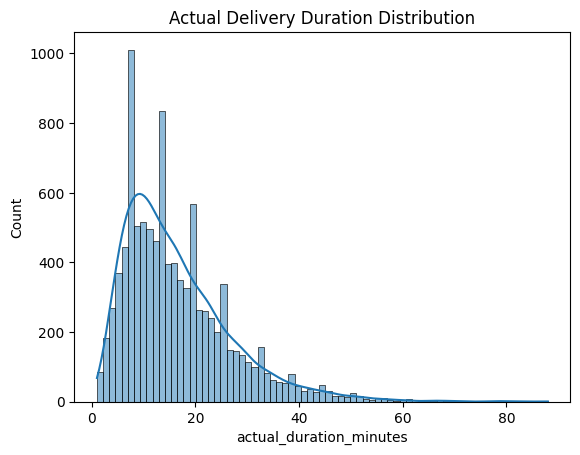

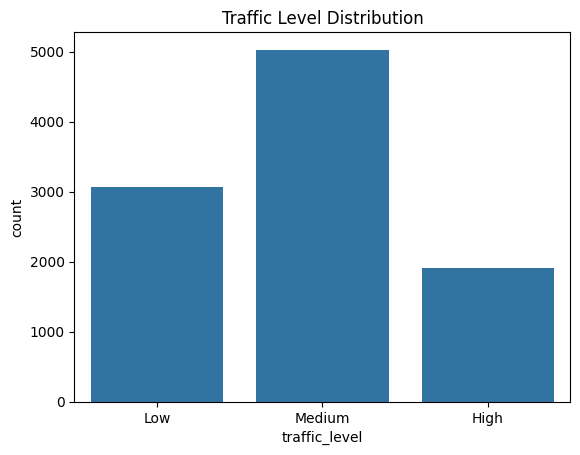

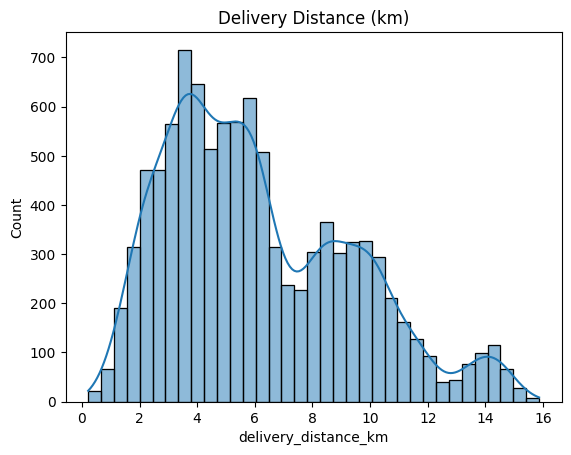

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Delivery duration distribution
sns.histplot(df['actual_duration_minutes'], kde=True)
plt.title('Actual Delivery Duration Distribution')
plt.show()

# Traffic levels
sns.countplot(x='traffic_level', data=df)
plt.title('Traffic Level Distribution')
plt.show()

# Delivery distance
sns.histplot(df['delivery_distance_km'], kde=True)
plt.title('Delivery Distance (km)')
plt.show()


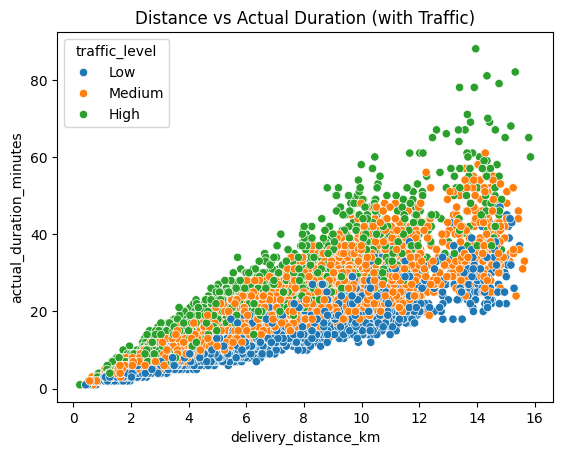

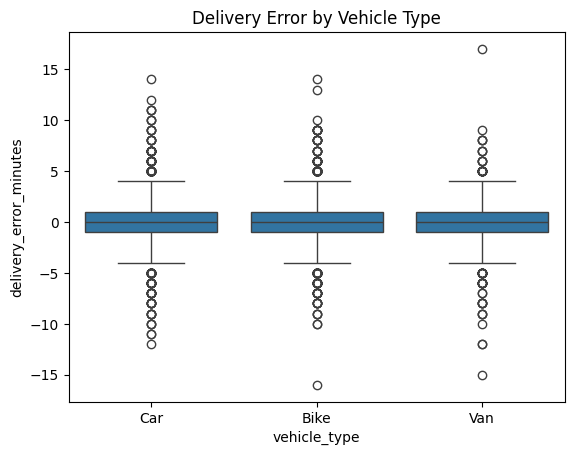

In [ ]:
# Distance vs. Delivery Duration
sns.scatterplot(x='delivery_distance_km', y='actual_duration_minutes', hue='traffic_level', data=df)
plt.title('Distance vs Actual Duration (with Traffic)')
plt.show()

# Vehicle type vs Delivery Error
sns.boxplot(x='vehicle_type', y='delivery_error_minutes', data=df)
plt.title('Delivery Error by Vehicle Type')
plt.show()


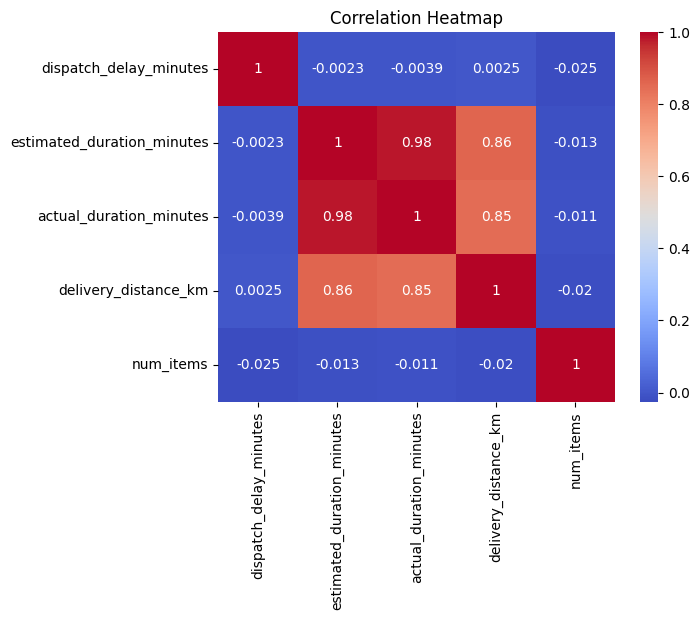

In [ ]:
numerics = ['dispatch_delay_minutes', 'estimated_duration_minutes', 'actual_duration_minutes', 'delivery_distance_km', 'num_items']
sns.heatmap(df[numerics].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
Q1 = df['actual_duration_minutes'].quantile(0.25)
Q3 = df['actual_duration_minutes'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR



In [ ]:
outliers = df[(df['actual_duration_minutes'] < lower_bound) | (df['actual_duration_minutes'] > upper_bound)]
print("Number of outliers:", outliers.shape[0])


Number of outliers: 294


In [ ]:
df_cleaned = df[(df['actual_duration_minutes'] >= lower_bound) & (df['actual_duration_minutes'] <= upper_bound)]


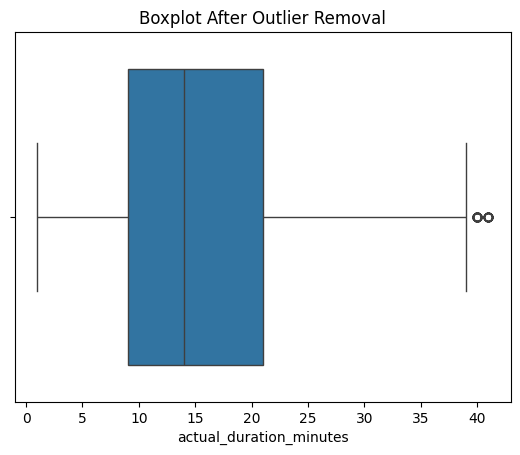

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df_cleaned['actual_duration_minutes'])
plt.title("Boxplot After Outlier Removal")
plt.show()


In [ ]:
df_cleaned['order_hour'] = df_cleaned['order_time'].dt.hour
df_cleaned['order_dayofweek'] = df_cleaned['order_time'].dt.dayofweek


<ipython-input-18-416b155f528e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['order_hour'] = df_cleaned['order_time'].dt.hour
<ipython-input-18-416b155f528e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['order_dayofweek'] = df_cleaned['order_time'].dt.dayofweek


In [ ]:
df_cleaned = pd.get_dummies(df_cleaned, columns=['vehicle_type', 'traffic_level'], drop_first=True)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Drop leakage-prone and non-numeric columns
X = df_cleaned.drop(columns=[
    'actual_duration_minutes',              # Target column
    'order_time', 'dispatch_time',
    'estimated_delivery_time', 'actual_delivery_time',
    'pickup_location', 'delivery_location', 'dropoff_location',
    'estimated_duration_minutes', 'delivery_error_minutes'  # Leakage
], errors='ignore')

# Define target variable
y = df_cleaned['actual_duration_minutes']

# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a baseline Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Performance:")
print(f"MAE: {mae:.2f} minutes")
print(f"RMSE: {rmse:.2f} minutes")
print(f"R² Score: {r2:.2f}")

Linear Regression Performance:
MAE: 2.93 minutes
RMSE: 3.82 minutes
R² Score: 0.80


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# Train Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.2f} minutes")
    print(f"RMSE: {rmse:.2f} minutes")
    print(f"R² Score: {r2:.2f}")
    print("-" * 40)

# Evaluate both models
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting")


Random Forest Performance:
MAE: 2.94 minutes
RMSE: 3.88 minutes
R² Score: 0.80
----------------------------------------
Gradient Boosting Performance:
MAE: 2.80 minutes
RMSE: 3.67 minutes
R² Score: 0.82
----------------------------------------


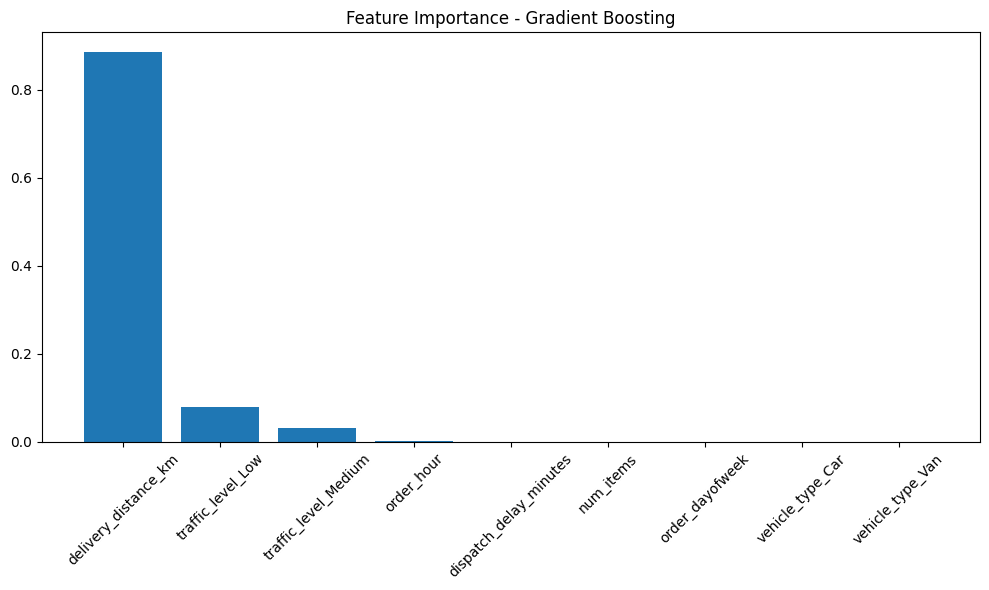

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
importances = gb.feature_importances_
feature_names = X.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10,6))
plt.title("Feature Importance - Gradient Boosting")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

gb_model = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(X_train_scaled, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best RMSE from Grid Search:", np.sqrt(-grid_search.best_score_))


Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best RMSE from Grid Search: 3.634342418283797


In [ ]:
import joblib

# Assuming you trained the best model as `best_model`
# The best model from GridSearchCV is available via grid_search.best_estimator_
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'delivery_time_model.pkl')
print("Model exported successfully.")

Model exported successfully.


In [ ]:
# To load the model later for prediction
loaded_model = joblib.load('delivery_time_model.pkl')

# Predict on new data (example: using X_test)
predictions = loaded_model.predict(X_test_scaled)


In [ ]:
!pip install fastapi uvicorn nest-asyncio pyngrok joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.6 MB/s eta 0:00:00


In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np
import nest_asyncio
from pyngrok import ngrok
import uvicorn

nest_asyncio.apply()


In [ ]:
# Load the trained model (upload first if needed)
model = joblib.load('delivery_time_model.pkl')

app = FastAPI()

class DeliveryInput(BaseModel):
    delivery_distance_km: float
    num_items: int
    dispatch_delay_minutes: float
    order_hour: int
    order_dayofweek: int
    vehicle_type_Bike: int
    vehicle_type_Car: int
    traffic_level_Medium: int
    traffic_level_High: int

@app.post("/predict")
def predict(data: DeliveryInput):
    input_array = np.array([[data.delivery_distance_km, data.num_items, data.dispatch_delay_minutes,
                             data.order_hour, data.order_dayofweek,
                             data.vehicle_type_Bike, data.vehicle_type_Car,
                             data.traffic_level_Medium, data.traffic_level_High]])
    prediction = model.predict(input_array)[0]
    return {"predicted_delivery_duration_minutes": round(prediction, 2)}


In [ ]:
!pip install pyngrok

In [ ]:
!pip install pyngrok uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.0 MB/s eta 0:00:00


In [ ]:
# In a separate cell or at the very beginning of your script for cleanup
try:
    print("Disconnecting ALL existing ngrok tunnels...")
    tunnels = ngrok.get_tunnels()
    for tunnel in tunnels:
        print(f"Disconnecting {tunnel.public_url}")
        ngrok.disconnect(tunnel.public_url)
    print("All existing tunnels disconnected.")
except Exception as e:
    print(f"Error during initial tunnel cleanup: {e}")

# Then, run the cell with the code block above to create and run the new tunnel

Disconnecting ALL existing ngrok tunnels...
Disconnecting https://b363-35-185-243-89.ngrok-free.app
Disconnecting https://6014-35-185-243-89.ngrok-free.app
Disconnecting https://619b-35-185-243-89.ngrok-free.app
All existing tunnels disconnected.


In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib

# Load the model
model = joblib.load("delivery_time_model.pkl")

# Define FastAPI app
app = FastAPI()

# Optional: Define a welcome route at root path
@app.get("/")
def read_root():
    return {"message": "FastAPI Delivery Duration Model is live!"}

# Define input schema
class DeliveryRequest(BaseModel):
    delivery_distance_km: float
    num_items: int
    dispatch_delay_minutes: float
    order_hour: int
    order_dayofweek: int
    vehicle_type_Bike: int
    vehicle_type_Car: int
    traffic_level_Medium: int
    traffic_level_High: int

# Define prediction endpoint
@app.post("/predict")
def predict_duration(request: DeliveryRequest):
    data = [[
        request.delivery_distance_km,
        request.num_items,
        request.dispatch_delay_minutes,
        request.order_hour,
        request.order_dayofweek,
        request.vehicle_type_Bike,
        request.vehicle_type_Car,
        request.traffic_level_Medium,
        request.traffic_level_High
    ]]
    prediction = model.predict(data)
    return {"predicted_delivery_duration_minutes": round(prediction[0], 2)}


In [ ]:
# ipython-input-6-0db65da6aabc - Make sure THIS cell is RUNNING when you access the ngrok URL

from pyngrok import ngrok
import os
import uvicorn
import nest_asyncio

nest_asyncio.apply()

# Set the authentication token
ngrok.set_auth_token("2y0000HwUbfceGAvTA1JOX0IMUW_5uBbxLeknW8z37bRXeLRv") # Use your actual auth token

public_url = None # Initialize public_url to None

try:
    # Connect to ngrok
    # This will establish the tunnel, but the server still needs to start
    # This call will raise an exception if the tunnel limit is reached
    public_url = ngrok.connect(8000).public_url
    print(f"FastAPI app is live at {public_url}")

    # Start the server
    # This call is BLOCKING. The cell will show [*] while the server is running.
    # Do NOT interrupt this cell while testing the ngrok URL.
    # 'app' is expected to be defined in a previous cell (ipython-input-36)
    # make sure the cell defining 'app = FastAPI()' is run before this one
    uvicorn.run(app, host="0.0.0.0", port=8000)

# Catch a broad exception to handle potential issues during ngrok connect or uvicorn run
except Exception as e:
    print(f"An error occurred: {e}")
    print("Ensure that the cell defining 'app = FastAPI()' has been run before this one.")
    print("Also check if port 8000 is already in use.")

    # Attempt to disconnect the specific tunnel if public_url was obtained
    if public_url:
        print(f"Attempting to disconnect tunnel {public_url} after error...")
        try:
            ngrok.disconnect(public_url) # Now we have the public_url to pass
            print("Tunnel disconnected.")
        except Exception as disconnect_e:
            print(f"Failed to disconnect tunnel: {disconnect_e}")

FastAPI app is live at https://caf8-35-185-243-89.ngrok-free.app


INFO:     Started server process [628]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     119.42.58.57:0 - "GET / HTTP/1.1" 200 OK
INFO:     119.42.58.57:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     119.42.58.57:0 - "GET /docs HTTP/1.1" 200 OK


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-1' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:68> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/main.py", line 580, in run
    server.run()
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    se

INFO:     119.42.58.57:0 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     119.42.58.57:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     119.42.58.57:0 - "POST /predict HTTP/1.1" 200 OK
